# DoggieTech Dog Image Classifier
A machine learning model to identify a dog breed

## Downloading data from Kaggle

In [ ]:
# Get dataset from Kaggle
!pip install kaggle
!kaggle datasets download -d jessicali9530/stanford-dogs-dataset

## Python Imports

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import zipfile
import pandas as pd
# import PIL
from PIL import Image
import imageio.v3 as iio
# import skimage as ski
import xml.etree.ElementTree as ET


## Unzip dataset for use

In [3]:
with zipfile.ZipFile("stanford-dogs-dataset.zip", "r") as z:
  z.extractall("sd_dataset")

## Image formatting helper methods

In [37]:
IMG_SIZE = 10

def convertImgToNpArray(anImage: Image):
  return np.array(anImage)

def cropImage(anImage, boundingBox: tuple):
  return anImage.crop(boundingBox)

def resizeImage(anImage: Image, aSize: int):
  return anImage.resize((aSize, aSize))

def to24Bit(anImage: Image):
  return anImage.convert('L')

def displayImage(anImageArray: np.array):
  plt.imshow(anImageArray)
  return

## Creating the dataframe to link attributes to images

In [38]:
def annotationParse(annotationDir : str, imageDir : str):
  annotationDict = [['id', 'breed','image location','xStart', 'yStart', 'xEnd', 'yEnd']]

  # For every cateogory (aka dog breed)
  for breedDir in os.listdir(annotationDir):
    # print(breedDir)
    # For every dog
    for sampleDog in os.listdir(os.path.join(annotationDir, breedDir)):
      # Generate XML root
      tree = ET.parse(os.path.join(annotationDir, breedDir, sampleDog))  
      root = tree.getroot()
      # Set dog image
      dogImg = os.path.join(imageDir, breedDir, sampleDog + ".jpg")
      # Get dog breed
      dogBreed = root[5][0].text
      # Get dog ID / file name (annotation file name)
      dogID = sampleDog
      # Get image bounding box
      xStart, yStart, xEnd, yEnd = (
        root[5][4][0].text,
        root[5][4][1].text,
        root[5][4][2].text,
        root[5][4][3].text
        )
      # Add dog info to dictionary
      annotationDict.append([dogID, dogBreed, dogImg, xStart, yStart, xEnd, yEnd])

  annotationDict = np.array(annotationDict)
  return pd.DataFrame(annotationDict[1:], columns=annotationDict[0])

## Organizing the images into a dataset

In [39]:
annotationDir = os.path.join("sd_dataset","annotations","Annotation")
imageDir = os.path.join("sd_dataset","images","Images")

dataFrame=annotationParse(annotationDir=annotationDir, imageDir=imageDir)
dataFrame.to_pickle("./DogBreedData.pkl")



## Creating lists for labels and inputs

In [40]:
# Take a DataFrame and generate labels and data for training
def createLabelAndDataLists(dataFrame: pd.DataFrame):
  data = []
  labels = []
  for item in dataFrame.itertuples():
    # Format the image, transform into np array
    boundingBox = (int(item[4]), int(item[5]), int(item[6]), int(item[7]))
    image = Image.open(item[3], 'r')
    # formattedImage = convertImgToNpArray(resizeImage(cropImage(anImage=image, boundingBox=boundingBox), 250))
    formattedImage = to24Bit(resizeImage(cropImage(anImage=image, boundingBox=boundingBox), IMG_SIZE))
    image.close()

    # Add the corresponding image and label to appropriate list
    data.append(formattedImage)
    labels.append(item[2])
  return data, labels


C:\Users\Tap\AppData\Local\Temp\ipykernel_13372\921852930.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


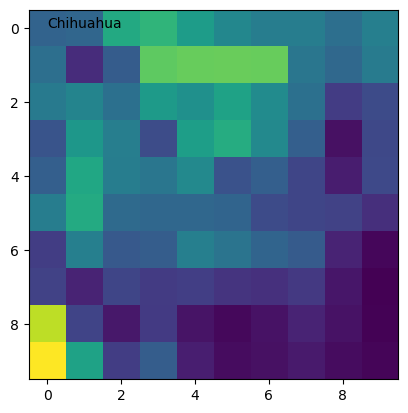

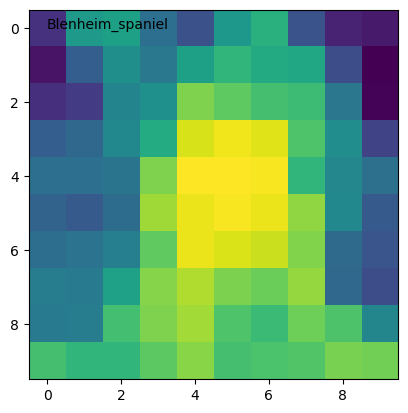

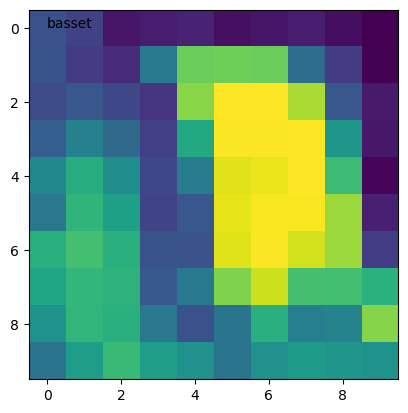

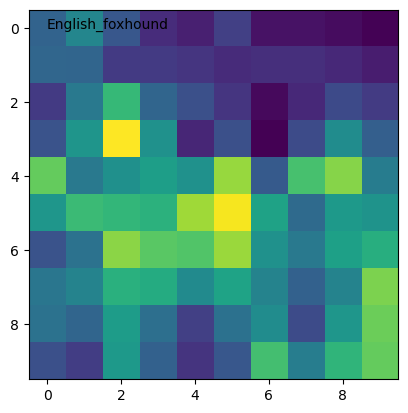

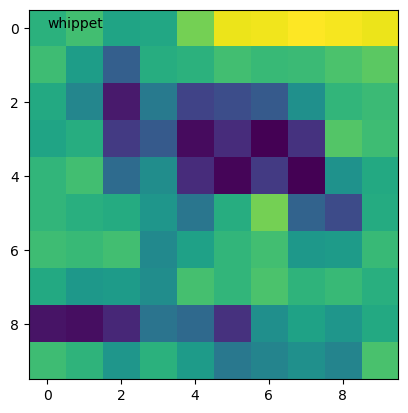

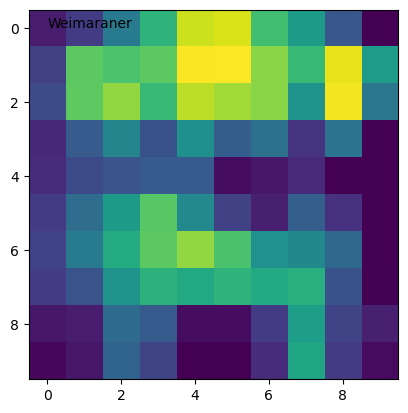

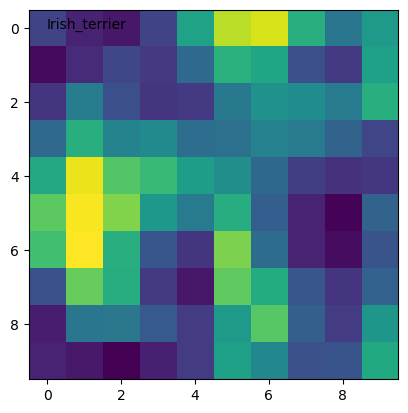

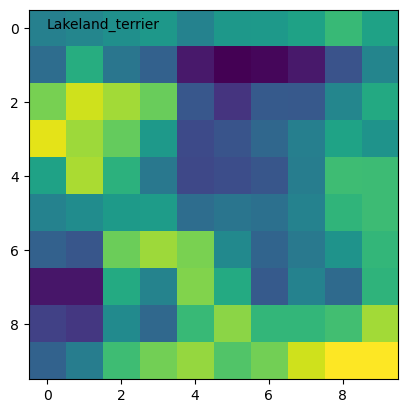

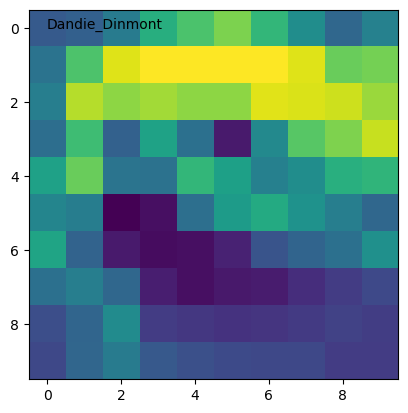

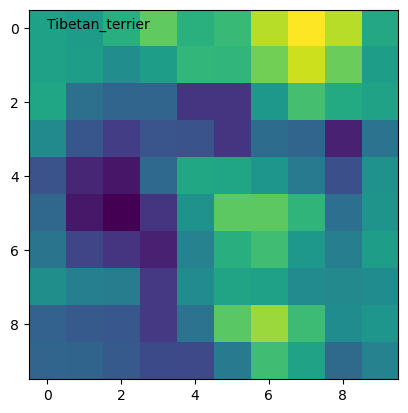

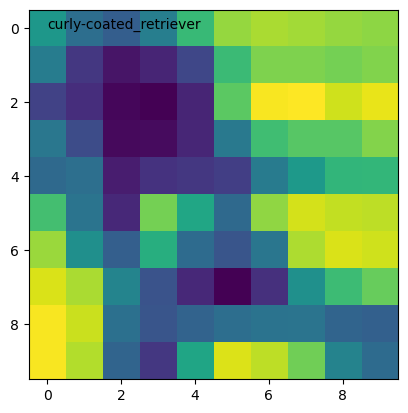

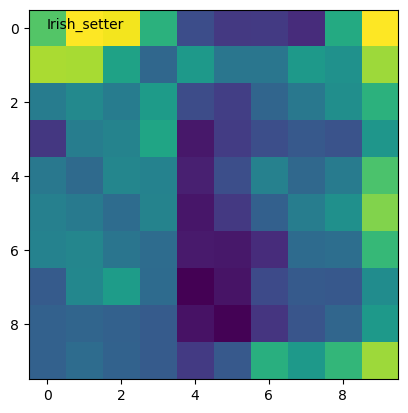

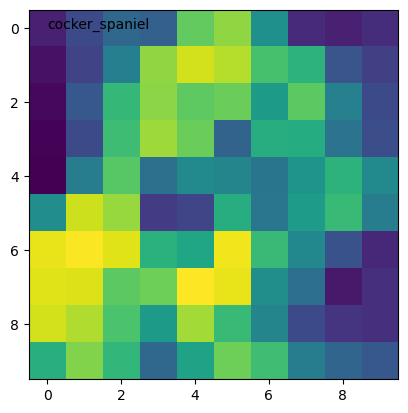

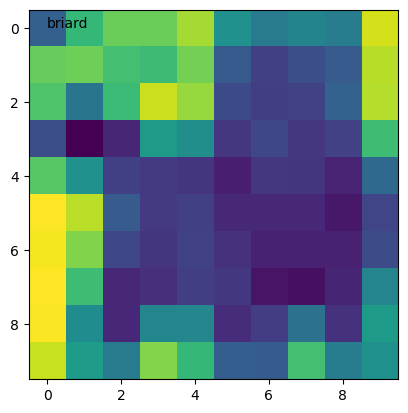

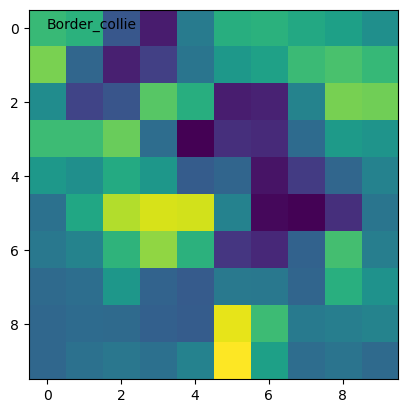

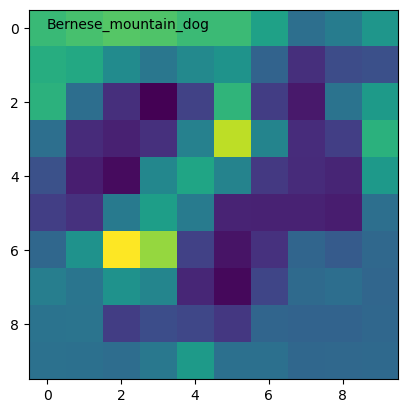

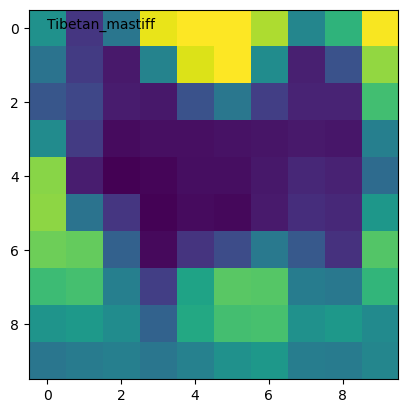

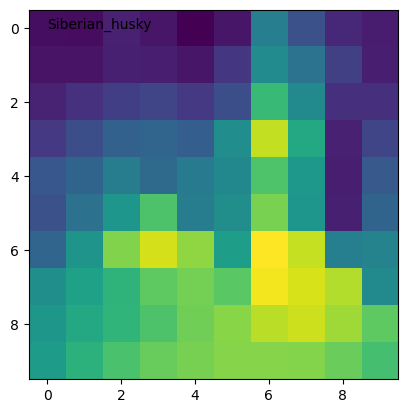

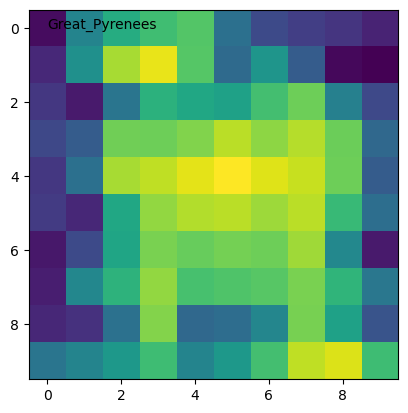

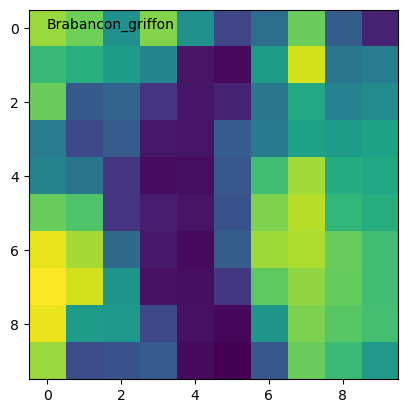

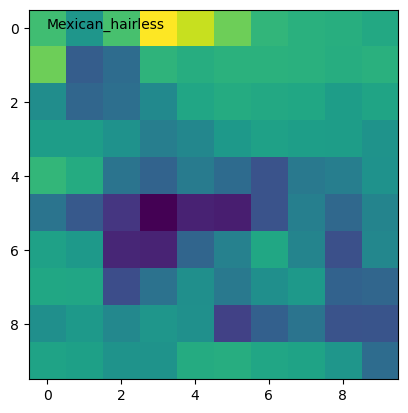

In [41]:
# Generate data and labels
data, labels = createLabelAndDataLists(dataFrame=dataFrame)

def showSamples():
  for i in range(0,len(data), 1000):
    plt.figure()
    plt.text(0,0,labels[i])
    plt.imshow(data[i])
showSamples()

# Final transformation of data for reading
dataCopy = []
for i in range(len(data)):
  item = np.array(data[i]).flatten()
  dataCopy.append(item)


## Writing the data to a file

In [42]:
import pickle
with open("./inputs_and_labels.pickle", 'wb') as f:
  pickle.dump({'data': dataCopy, 'labels':labels}, f)